# Open Traffic Reporter

## Map-Matching Optimization

The Open Traffic Reporter map-matching service is based on the Hidden Markov Model (HMM) design of [Newton and Krumm (2009)](http://research.microsoft.com/en-us/um/people/jckrumm/Publications%202009/map%20matching%20ACM%20GIS%20camera%20ready.pdf). Skipping over 99% of the innerworkings of HMMs, there are two principal parameters in the HMM algorithm that must be estimated from data (for more detail see [here](https://en.wikipedia.org/wiki/Hidden_Markov_model)).

The first parameter that needs tuning is $\sigma_z$. It appears in the equation below which expresses the probability of recording the GPS measurement $z_t$ from road segment $r_i$. 

$$ p(z_t|r_i) = \frac{1}{\sqrt{2 \pi \sigma_z}} e^{-0.5(\frac{||z_t - x_{t,i}||_{\text{great circle}}}{\sigma_z})^2}$$

In [1]:
from __future__ import division
from matplotlib import pyplot as plt
import numpy as np
import os
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
%matplotlib inline

In [2]:
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')

### 1. Generate Random Routes

#### Generate routes from Google Maps POIs or Mapzen Venues

In [3]:
# routeList = val.get_POI_routes_by_length('Paris', 1, 5, 20, gmapsKey)
routeList = val.get_routes_by_length('San Francisco', 1, 5, 1, mapzenKey)

#### Save or load a specific set of routes

In [10]:
# routeList = pickle.load(open('sf_routes.pkl','rb'))
# pickle.dump(routeList, open('saf_routes.pkl','wb'))

### 2. Grid Search for Optimal Parameter Values

In [5]:
noiseLevels = np.linspace(0, 100, 21)
# noiseLevels = [50]
sampleRates = [1, 5, 10, 20, 30]
# sampleRates = [10]
betas = np.arange(1, 21, 1)
sigmaZs = np.arange(1, 21, 1)

# val.grid_search_hmm_params()


### 3. Plot the Curves

In [5]:
df['score'] = df['score'].astype(float)
df['beta'] = df['beta'].astype(float)
df['sigma_z'] = df['sigma_z'].astype(float)

In [5]:
import numpy as np

In [7]:
int(np.ceil(5. / 2))

3

In [1]:
5 % 2

1

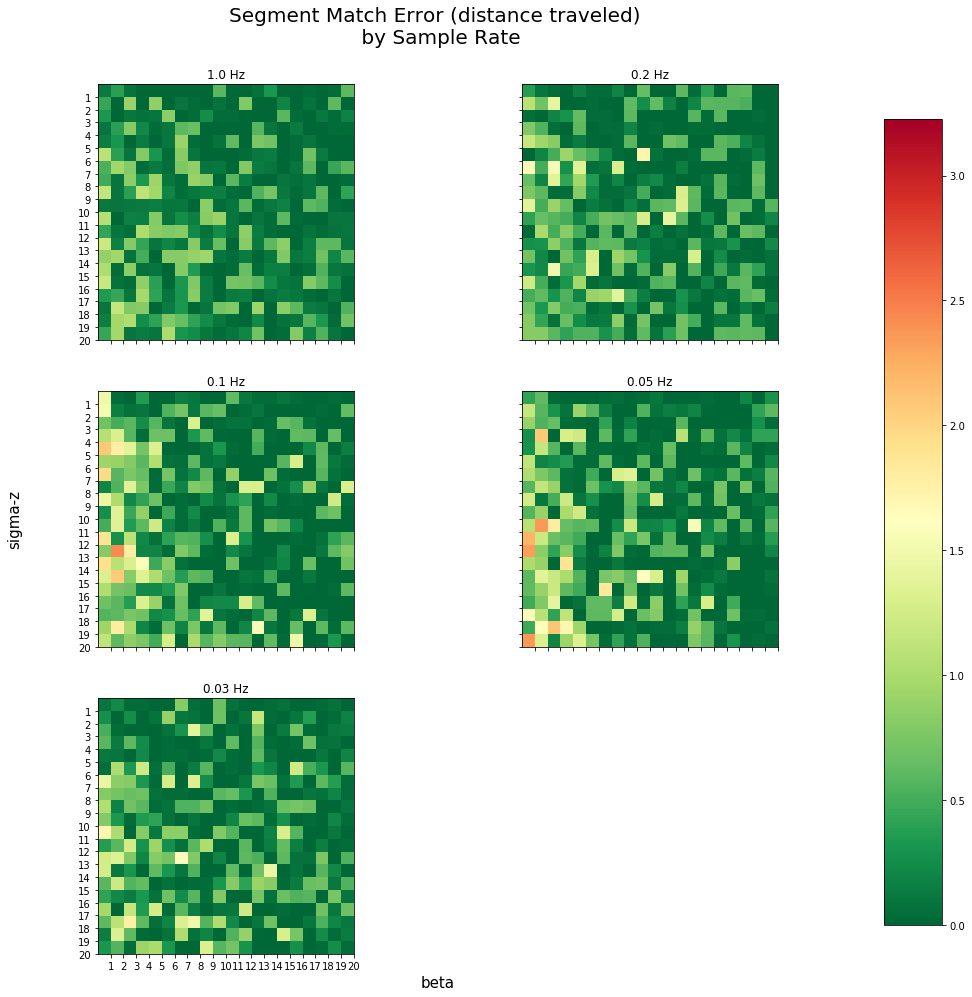

In [6]:
fig, axarr = plt.subplots(nrows=3, ncols=2, 
                          sharex=True, 
                          sharey=True, 
                          figsize=(16, 16)
                         )

axarr[-1, -1].axis('off')
for i, rate in enumerate(sampleRates):
    ax = axarr.flat[i]
    paramDf = df[df['sample_rate'] == rate]   
    betaScores = paramDf.groupby('beta').agg('mean').reset_index()
    sigmaZScores = paramDf.groupby('sigma_z').agg('mean').reset_index()
    scores = np.ones((len(betaScores), len(sigmaZScores)))
    for i, beta in enumerate(betas):
        for j, sigmaZ in enumerate(sigmaZs):
            scores[i,j] = paramDf.loc[(paramDf['beta'] == beta) & (paramDf['sigma_z'] == sigmaZ), 'score'].values[0]
    im = ax.imshow(
        scores, interpolation='None', cmap='RdYlGn_r', vmin=0, vmax=max(df['score']),
        extent=[0,max(sigmaZs),max(betas),0])
    ax.set_xticks([beta for beta in betas if not beta % 1])
    ax.set_yticks([sigmaZ for sigmaZ in sigmaZs if not sigmaZ % 1])
    ax.set_xticklabels([int(beta) for beta in betas if not beta % 1])
    ax.set_yticklabels([int(sigmaZ) for sigmaZ in sigmaZs if not sigmaZ % 1])
    ax.set_adjustable('box-forced')
    hz = str(round(1 / rate, 2))
    ax.set_title(hz + ' Hz')
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(
    labelcolor='none', top='off', bottom='off', left='off', right='off')
ax.set_xlabel('beta', fontsize=15)
ax.set_ylabel('sigma-z', fontsize=15)
ax.set_title('Segment Match Error (distance traveled) \n by Sample Rate', fontsize=20, y=1.04)
plt.show()

# TESTING TESTING TESTING

In [32]:
from __future__ import division
from matplotlib import pyplot as plt
from matplotlib import cm, colors, patheffects
import numpy as np
import os
import glob
import urllib
import json
import pandas as pd
from random import shuffle, choice
import pickle
import sys; sys.path.insert(0, os.path.abspath('..'));
import validator.validator as val
%matplotlib inline
turnPenaltyFactor = 500
sigmaZ = 3
beta = 3
saveResults = False
sampleRates = [10]
noiseLevels = [50]
mapzenKey = os.environ.get('MAPZEN_API')
gmapsKey = os.environ.get('GOOGLE_MAPS')
routeList = val.get_routes_by_length('San Francisco', 1, 5, 1, mapzenKey)

In [33]:
distance_metrics = [
    'segments', 'distance traveled', 'undermatches',
    'undermatch distance', 'overmatches', 'overmatch distance']

speed_metrics = [
    'edge_speed_error', 'pct_edges_too_fast', 'pct_edges_too_slow',
    'segment_speed_error', 'pct_segments_too_fast',
    'pct_segments_too_slow', 'segment_speed_error_matched',
    'segment_speed_error_missed']

scoring_metrics = distance_metrics + speed_metrics

df = pd.DataFrame(columns=[
    'route', 'noise', 'sample_rate', 'avg_density'] +
    scoring_metrics + ['route_url', 'trace_attr_url', 'reporter_url'])

speedDf = pd.DataFrame(columns=[
    'route_name', 'segment_id', 'sample_rate', 'noise', 'pct_error',
    'matched'])
outDfRow = -1
tpf = turnPenaltyFactor

for i, rteCoords in enumerate(routeList):

    stName = rteCoords[0].keys()[0].encode("ascii", "ignore")
    endName = rteCoords[1].keys()[0].encode("ascii", "ignore")
    routeName = '{0}_to_{1}'.format(stName, endName)
    shape, routeUrl = val.get_route_shape(rteCoords)
    if shape is None:
        print routeUrl
        continue
    edges, matchedPts, shapeCoords, traceAttrUrl = val.get_trace_attrs(
        shape, shapeMatch="map_snap", turnPenaltyFactor=tpf, sigmaZ=sigmaZ,
        beta=beta)
    edges = val.get_coords_per_second(shapeCoords, edges, '2768')
    avgDensity = np.mean([edge['density'] for edge in edges])

    for noise in noiseLevels:
        noise = round(noise, 3)

        for sampleRate in sampleRates:
            print(
                "Route: {0} // Noise Level: "
                "{1} // Sample Rate: {2}".format(
                    i, noise, sampleRate))
            Hz = round(1 / sampleRate, 3)
            outDfRow += 1
            df.loc[
                outDfRow, [
                    'route', 'noise', 'sample_rate',
                    'route_url', 'trace_attr_url']] = [
                        routeName, noise, sampleRate, routeUrl,
                        traceAttrUrl]
            dfEdges = val.format_edge_df(edges)
            if dfEdges['num_segments'].max() > 1:
                break
            dfEdges, jsonDict, geojson, gpsMatchEdges, gpsMatchShape = val.synthesize_gps(
                dfEdges, shapeCoords, '2768', noise=noise,
                sampleRate=sampleRate, turnPenaltyFactor=tpf, beta=beta,
                sigmaZ=sigmaZ)

            if jsonDict is None or geojson is None:
                msg = "Trace attributes tried to call more" + \
                    " edges than are present in the route shape".format(
                        routeName)
                df.loc[outDfRow, scoring_metrics + ['reporter_url']] = \
                    [None] * 6 + [msg]
                continue
            segments, reportUrl = val.get_reporter_segments(jsonDict)
            if segments is None:
                continue
            elif segments == 0:
                msg = 'Reporter found 0 segments.'
                df.loc[outDfRow, scoring_metrics + ['reporter_url']] = \
                    [-1] * 14 + [reportUrl]
                continue
            segScore, distScore, undermatchScore, undermatchLenScore, \
                overmatchScore, overmatchLenScore = val.get_match_scores(
                    segments, dfEdges, gpsMatchEdges)
            edgeSpeedScore, pctTooFastEdges, pctTooSlowEdges, \
                segSpeedScore, pctTooFastSegs, pctTooSlowSegs, \
                segMatchSpeedScore, segMissSpeedScore, \
                segSpeedDf = val.get_speed_scores(
                    gpsMatchEdges, dfEdges, segments, sampleRate)
            if len(segSpeedDf) < 1:
                continue
            segSpeedDf.loc[:, 'route_name'] = routeName
            segSpeedDf.loc[:, 'sample_rate'] = sampleRate
            segSpeedDf.loc[:, 'noise'] = noise
            speedDf = pd.concat((speedDf, segSpeedDf), ignore_index=True)

            df.loc[outDfRow, scoring_metrics + ['reporter_url']] = [
                segScore, distScore, undermatchScore, undermatchLenScore,
                overmatchScore, overmatchLenScore, edgeSpeedScore,
                pctTooFastEdges, pctTooSlowEdges, segSpeedScore,
                pctTooFastSegs, pctTooSlowSegs, segMatchSpeedScore,
                segMissSpeedScore, reportUrl]
            df.loc[outDfRow, 'avg_density'] = avgDensity
            df['segments'] = df['segments'].astype(float)
            df['overmatches'] = df['overmatches'].astype(float)
            df['undermatches'] = df['undermatches'].astype(float)
            df['distance traveled'] = df['distance traveled'].astype(float)
            df['overmatch distance'] = df[
                'overmatch distance'].astype(float)
            df['undermatch distance'] = df[
                'undermatch distance'].astype(float)
            df['avg_density'] = df['avg_density'].astype(float)
            df['noise'] = df['noise'].astype(float)
            df['sample_rate'] = df['sample_rate'].astype(float)
            df['score_density'] = df['segments'] * df['avg_density']

            if saveResults:
                with open(
                    '../data/trace_{0}_to_{1}_w_{2}'
                    '_m_noise_at_{3}_Hz.geojson'.format(
                        stName, endName, str(noise), str(Hz)), 'w+') as fp:
                            json.dump(geojson, fp)

dfGpsMatchEdges = pd.DataFrame(gpsMatchEdges)

dfGpsMatchEdges = dfGpsMatchEdges[[
        'id', 'begin_shape_index', 'end_shape_index','traffic_segments']]

dfGpsMatchEdges['segment_id'] = dfGpsMatchEdges['traffic_segments'].apply(
        lambda x: str(x[0]['segment_id']) if type(x) is list else None)

merged = pd.merge(dfGpsMatchEdges, speedDf, on='segment_id', how='left')

merged = merged[['begin_shape_index','end_shape_index','pct_error']]

from geojson import Feature, MultiLineString, FeatureCollection

tooFastSegs = []
okSegs = []
notMatchedSegs = []
threshold = 0.05

for i, row in merged.iterrows():
    segCoords = gpsMatchShape[int(row['begin_shape_index']):int((row['end_shape_index'] + 1))]
    if pd.isnull(row['pct_error']):
        notMatchedSegs.append(segCoords)
    elif row['pct_error'] > threshold:
        tooFastSegs.append(segCoords)
    else:
        okSegs.append(segCoords)

tooFastSegs = Feature(geometry=MultiLineString(
            tooFastSegs), properties={"style": {
                "color": "#cc3232",
                "weight": "3px",
                "opacity": 1.0,
                "name": "too_fast_segs"}})

okSegs = Feature(geometry=MultiLineString(
            okSegs), properties={"style": {
                "color": "#2dc937",
                "weight": "3px",
                "opacity": 1.0,
                "name": "ok_segs"}})

notMatchedSegs = Feature(geometry=MultiLineString(
            notMatchedSegs), properties={"style": {
                "color": "#ffff66",
                "weight": "3px",
                "opacity": 1.0,
                "name": "not_matched_segs"}})

geojson['features'].extend((tooFastSegs, okSegs, notMatchedSegs))

from ipywidgets import Layout
from ipyleaflet import (
    Map,
    TileLayer,
    Circle,
    GeoJSON
)
zoomLevel=14

data = geojson
ctrLon, ctrLat = np.mean(
    np.array(data['features'][0]['geometry']['coordinates']), axis=0)
url = "http://stamen-tiles-{s}.a.ssl.fastly.net/toner-lite/{z}/{x}/{y}.png"
provider = TileLayer(url=url, opacity=1)
center = [ctrLat, ctrLon]
m = Map(default_tiles=provider, center=center, zoom=zoomLevel)
m.layout = Layout(width='100%', height='800px')
trueRouteCoords, resampledCoords, gpsRouteCoords, \
    displacementLines, gpsMatchShape, tooFastSegs, okSegs, notMatchedSegs = data['features']
g = GeoJSON(data=FeatureCollection([
    trueRouteCoords, gpsMatchShape, 
    tooFastSegs, okSegs, notMatchedSegs]))
m.add_layer(g)
for coords in resampledCoords['geometry']['coordinates']:
    cm = Circle(
        location=coords[::-1], radius=10, weight=1, color='#ff9900',
        opacity=1.0, fill_opacity=0.6, fill_color='#ff9900')
    m.add_layer(cm)
for coords in gpsRouteCoords['geometry']['coordinates']:
    cm = Circle(
        location=coords[::-1], radius=10, weight=1, color='#0000ff',
        opacity=1.0, fill_opacity=0.4, fill_color='#0000ff')
    m.add_layer(cm)
g = GeoJSON(data=displacementLines)
m.add_layer(g)
m

Route: 0 // Noise Level: 50.0 // Sample Rate: 10


In [34]:
dir(m)

['__add__',
 '__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getstate__',
 '__hash__',
 '__iadd__',
 '__init__',
 '__isub__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_notifiers',
 '_call_widget_constructed',
 '_comm_changed',
 '_compare',
 '_config_changed',
 '_cross_validation_lock',
 '_default_keys',
 '_default_layout',
 '_default_options',
 '_default_tiles',
 '_display_callbacks',
 '_dom_classes',
 '_east',
 '_find_my_config',
 '_fire_children_displayed',
 '_handle_custom_msg',
 '_handle_displayed',
 '_handle_leaflet_event',
 '_handle_msg',
 '_holding_sync',
 '_ipython_display_',
 '_is_numpy',
 '_load_config',
 '_lock_property',
 '_log_default',
 '_model_id',
 '_model_module',
 '_model_module_version',
 '_model_name',
 '_msg_callbacks',
 '_north',
 '_notify_trait',
 '_property_lock',
 '_regis

In [35]:
geojson

{"features": [{"geometry": {"coordinates": [[-122.416489, 37.777442], [-122.41758, 37.776576], [-122.417618, 37.776542], [-122.417847, 37.776371], [-122.418763, 37.775653], [-122.41922, 37.775234], [-122.419419, 37.77639], [-122.419533, 37.776958], [-122.41961, 37.777317], [-122.419724, 37.777782], [-122.419747, 37.777893], [-122.419823, 37.778278], [-122.420189, 37.780082], [-122.420289, 37.780578], [-122.42038, 37.781044], [-122.420479, 37.781509], [-122.42051, 37.781654], [-122.420571, 37.78197], [-122.420762, 37.782905], [-122.420853, 37.783374], [-122.420868, 37.783428], [-122.420945, 37.783836], [-122.421044, 37.784305], [-122.421135, 37.784774], [-122.421227, 37.78524], [-122.421326, 37.785705], [-122.421418, 37.786182], [-122.421517, 37.786632], [-122.421608, 37.787101], [-122.4217, 37.787567], [-122.421792, 37.788032], [-122.421891, 37.788497], [-122.420319, 37.788696], [-122.418679, 37.788906], [-122.417038, 37.789115], [-122.415764, 37.789276], [-122.415391, 37.789325], [-12